In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Aug 21 21:31:34 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
#mounting google drive on colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import copy
from scipy import signal

In [4]:
X_train=np.load("./drive/MyDrive/MSc Thesis/Experiments/all_pairs_ts_data_X_trainv7_exp1_exp5_strat_v2.npy")
y_train=np.load("./drive/MyDrive/MSc Thesis/Experiments/all_pairs_ts_data_y_trainv7_exp1_exp5_strat_v2.npy").astype(int)

X_test=np.load("./drive/MyDrive/MSc Thesis/Experiments/all_pairs_ts_data_X_testv7_exp1_exp5_strat_v2.npy")
y_test=np.load("./drive/MyDrive/MSc Thesis/Experiments/all_pairs_ts_data_y_testv7_exp1_exp5_strat_v2.npy").astype(int)


In [5]:
def calc_freq_signal(arr):
    freqs, psd = signal.welch(arr, fs=10)
    return psd

X_train_f=np.apply_along_axis(calc_freq_signal, 1, X_train)
X_test_f=np.apply_along_axis(calc_freq_signal, 1, X_test)


/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 50, using nperseg = 50
  .format(nperseg, input_length))


In [7]:
X_train_1d=np.gradient(X_train,axis=1)
X_test_1d=np.gradient(X_test,axis=1)
X_train=np.dstack([X_train,X_train_1d])
X_test=np.dstack([X_test,X_test_1d])

In [8]:
print(X_train.shape)

(21347, 50, 8)


In [9]:
def custom_scaler(X, range=(0, 1),min=None,max=None):
    mi, ma = range
    if(min==None):
      min=X.min()
      max=X.max()
      print("\nTrain_Scaling:- min=",min," max=",max)
    X_std = (X - min) / (max - min)
    X_scaled = X_std * (ma - mi) + mi
    return min,max,X_scaled

In [10]:
# Feature Scaling
#X_train contains 8 signals x1,x2,y1,y2,x1d,2d,y1d,y2d
X_train_scaled=copy.copy(X_train)
X_test_scaled=copy.copy(X_test)

min_temp,max_temp,X_train_scaled[:,:,0:2]=custom_scaler(X_train_scaled[:,:,0:2],range=(0,1))
_,_,X_test_scaled[:,:,0:2]=custom_scaler(X_test_scaled[:,:,0:2],range=(0,1),min=min_temp,max=max_temp)

min_temp,max_temp,X_train_scaled[:,:,2:4]=custom_scaler(X_train_scaled[:,:,2:4],range=(0,1))
_,_,X_test_scaled[:,:,2:4]=custom_scaler(X_test_scaled[:,:,2:4],range=(0,1),min=min_temp,max=max_temp)

min_temp,max_temp,X_train_scaled[:,:,4:6]=custom_scaler(X_train_scaled[:,:,4:6],range=(0,1))
_,_,X_test_scaled[:,:,4:6]=custom_scaler(X_test_scaled[:,:,4:6],range=(0,1),min=min_temp,max=max_temp)

min_temp,max_temp,X_train_scaled[:,:,6:8]=custom_scaler(X_train_scaled[:,:,6:8],range=(0,1))
_,_,X_test_scaled[:,:,6:8]=custom_scaler(X_test_scaled[:,:,6:8],range=(0,1),min=min_temp,max=max_temp)


print("Frequency signals scaling:-------------")
#X_train contains 8 signals x1f,x2f,y1f,y2f
X_train_scaled_f=copy.copy(X_train_f)
X_test_scaled_f=copy.copy(X_test_f)

min_temp,max_temp,X_train_scaled_f[:,:,0:2]=custom_scaler(X_train_scaled_f[:,:,0:2],range=(0,1))
_,_,X_test_scaled_f[:,:,0:2]=custom_scaler(X_test_scaled_f[:,:,0:2],range=(0,1),min=min_temp,max=max_temp)

min_temp,max_temp,X_train_scaled_f[:,:,2:4]=custom_scaler(X_train_scaled_f[:,:,2:4],range=(0,1))
_,_,X_test_scaled_f[:,:,2:4]=custom_scaler(X_test_scaled_f[:,:,2:4],range=(0,1),min=min_temp,max=max_temp)



Train_Scaling:- min= -28.15271043323709  max= 37.07106781186548

Train_Scaling:- min= -33.71032582929608  max= 33.60247434978709

Train_Scaling:- min= -12.320254626359059  max= 14.385756524143293

Train_Scaling:- min= -25.40645604165462  max= 18.311546903226954
Frequency signals scaling:-------------

Train_Scaling:- min= 0.0  max= 717.6949576342864

Train_Scaling:- min= 0.0  max= 1338.5393381137053


In [11]:
print(X_train_scaled.shape)
print(X_train_scaled_f.shape)

(21347, 50, 8)
(21347, 26, 4)


In [12]:

# Part 2 - Building the RNN

# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Input
from tensorflow.keras import layers
import keras

input_1 = Input((X_train_scaled.shape[1], X_train_scaled.shape[2]))
input_2 = Input((X_train_scaled_f.shape[1], X_train_scaled_f.shape[2]))

x1=LSTM(units = 100, return_sequences = True)(input_1)
x1=LSTM(units = 50)(x1)

x2=LSTM(units = 100, return_sequences = True)(input_2)
x2=LSTM(units = 50)(x2)

x = layers.concatenate([x1, x2])

output_layer = layers.Dense(1, activation="sigmoid")(x)

classifier=keras.Model(inputs=[input_1, input_2], outputs=output_layer)


# Compiling the RNN
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])


In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint("./drive/MyDrive/MSc Thesis/Experiments/models/LSTM_1d_freq_exp1_exp5_strat_v2.h5",
                             monitor="val_accuracy",
                             mode="max",
                             save_best_only = True,
                             verbose=1)


earlystop = EarlyStopping(monitor = 'val_accuracy', # value being monitored for improvement
                          min_delta = 0, #Abs value and is the min change required before we stop
                          patience = 20, #Number of epochs we wait before stopping 
                          verbose = 1,
                          restore_best_weights = True) #keeps the best weigths once stopped

# we put our call backs into a callback list
callbacks = [earlystop,checkpoint]


In [14]:
# Fitting the RNN to the Training set
history=classifier.fit([X_train_scaled,X_train_scaled_f], y_train[:,0], epochs = 200, batch_size = 64,validation_data=([X_test_scaled,X_test_scaled_f],y_test[:,0]),callbacks=callbacks)


Epoch 1/200
333/334 [============================>.] - ETA: 0s - loss: 0.5393 - accuracy: 0.7142
Epoch 1: val_accuracy improved from -inf to 0.72702, saving model to ./drive/MyDrive/MSc Thesis/Experiments/models/LSTM_1d_freq_exp1_exp5_strat_v2.h5
334/334 [==============================] - 16s 18ms/step - loss: 0.5393 - accuracy: 0.7142 - val_loss: 0.5209 - val_accuracy: 0.7270
Epoch 2/200
332/334 [============================>.] - ETA: 0s - loss: 0.5177 - accuracy: 0.7150
Epoch 2: val_accuracy did not improve from 0.72702
334/334 [==============================] - 4s 12ms/step - loss: 0.5176 - accuracy: 0.7152 - val_loss: 0.5143 - val_accuracy: 0.7133
Epoch 3/200
334/334 [==============================] - ETA: 0s - loss: 0.5070 - accuracy: 0.7240
Epoch 3: val_accuracy did not improve from 0.72702
334/334 [==============================] - 4s 12ms/step - loss: 0.5070 - accuracy: 0.7240 - val_loss: 0.4955 - val_accuracy: 0.7140
Epoch 4/200
330/334 [============================>.] - ETA: 

In [15]:
classifier.evaluate([X_test_scaled,X_test_scaled_f],y_test[:,0])

90/90 [==============================] - 1s 6ms/step - loss: 0.1708 - accuracy: 0.9453


[0.17076759040355682, 0.945263147354126]

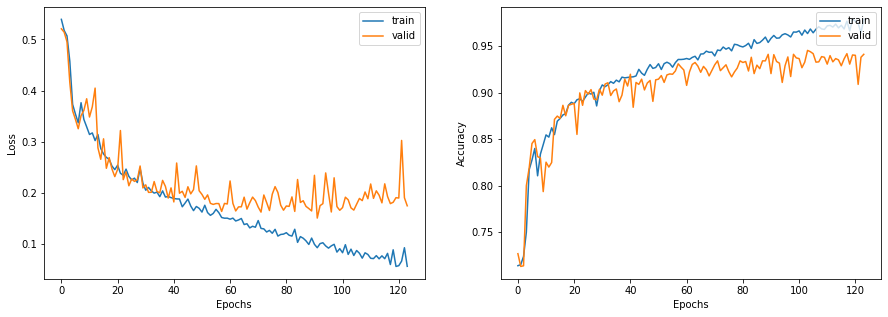

In [16]:
import matplotlib.pyplot as plt
def display_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "valid"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2.plot(history.history["accuracy"])
    ax2.plot(history.history["val_accuracy"])
    ax2.legend(["train", "valid"], loc="upper right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    plt.show()

display_learning_curves(history)

In [17]:
import tensorflow as tf
temp=tf.keras.models.load_model("./drive/MyDrive/MSc Thesis/Experiments/models/LSTM_1d_freq_exp1_exp5_strat_v2.h5")

In [18]:
temp.evaluate([X_test_scaled,X_test_scaled_f], y_test[:,0], 1)

2850/2850 [==============================] - 15s 5ms/step - loss: 0.1708 - accuracy: 0.9453


[0.1707671731710434, 0.945263147354126]

In [19]:
temp.evaluate([X_test_scaled,X_test_scaled_f], y_test[:,0])

90/90 [==============================] - 2s 6ms/step - loss: 0.1708 - accuracy: 0.9453


[0.17076759040355682, 0.945263147354126]

In [20]:
y_pred = temp.predict([X_test_scaled,X_test_scaled_f])
y_pred= (y_pred>=0.5).astype(int)

In [21]:
y_pred

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [22]:
from sklearn.metrics import accuracy_score, f1_score, classification_report,confusion_matrix

In [23]:
confusion_matrix(y_test[:,0],y_pred)

array([[1941,   93],
       [  63,  753]])

In [24]:
accuracy_score(y_test[:,0],y_pred)

0.9452631578947368

In [25]:
f1_score(y_test[:,0],y_pred)

0.9061371841155235

In [26]:
print(classification_report(y_test[:,0],y_pred))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96      2034
           1       0.89      0.92      0.91       816

    accuracy                           0.95      2850
   macro avg       0.93      0.94      0.93      2850
weighted avg       0.95      0.95      0.95      2850



In [27]:
###Collect F-Score 10 times
import sklearn
from tqdm.notebook import tqdm
def calc_f1_score(X_train_scaled,X_test_scaled,X_train_scaled_f,X_test_scaled_f,y_train,y_test,earlystop):
  input_1 = Input((X_train_scaled.shape[1], X_train_scaled.shape[2]))
  input_2 = Input((X_train_scaled_f.shape[1], X_train_scaled_f.shape[2]))
  x1=LSTM(units = 100, return_sequences = True)(input_1)
  x1=LSTM(units = 50)(x1)
  x2=LSTM(units = 100, return_sequences = True)(input_2)
  x2=LSTM(units = 50)(x2)
  x = layers.concatenate([x1, x2])
  output_layer = layers.Dense(1, activation="sigmoid")(x)
  classifier=keras.Model(inputs=[input_1, input_2], outputs=output_layer)
  # Compiling the RNN
  classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
  classifier.fit([X_train_scaled,X_train_scaled_f], y_train[:,0], epochs = 500, batch_size = 64,validation_data=([X_test_scaled,X_test_scaled_f],y_test[:,0]),callbacks=[earlystop])
  y_pred = classifier.predict([X_test_scaled,X_test_scaled_f])
  y_pred= (y_pred>=0.5).astype(int)
  return(sklearn.metrics.f1_score(y_test[:,0],y_pred))

f1_score_list=[]
for i in tqdm(range(10)):
  f1_score_list=f1_score_list+[calc_f1_score(X_train_scaled,X_test_scaled,X_train_scaled_f,X_test_scaled_f,y_train,y_test,earlystop)]
  print("Number of iterations",len(f1_score_list))
  print("F1-scores: ",f1_score_list)
  print("Average F1-Score",np.mean(f1_score_list))
  print("Std Dev F1-Score",np.std(f1_score_list))
  print("Error bar F1-Score",np.std(f1_score_list)/np.sqrt(len(f1_score_list)))


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/500
334/334 [==============================] - 10s 16ms/step - loss: 0.5726 - accuracy: 0.7087 - val_loss: 0.5722 - val_accuracy: 0.7137
Epoch 2/500
334/334 [==============================] - 4s 12ms/step - loss: 0.5479 - accuracy: 0.7141 - val_loss: 0.4479 - val_accuracy: 0.7309
Epoch 3/500
334/334 [==============================] - 4s 12ms/step - loss: 0.3897 - accuracy: 0.8083 - val_loss: 0.3601 - val_accuracy: 0.8312
Epoch 4/500
334/334 [==============================] - 4s 12ms/step - loss: 0.3632 - accuracy: 0.8239 - val_loss: 0.3709 - val_accuracy: 0.8239
Epoch 5/500
334/334 [==============================] - 4s 12ms/step - loss: 0.3484 - accuracy: 0.8333 - val_loss: 0.3460 - val_accuracy: 0.8323
Epoch 6/500
334/334 [==============================] - 4s 12ms/step - loss: 0.3308 - accuracy: 0.8433 - val_loss: 0.3339 - val_accuracy: 0.8309
Epoch 7/500
334/334 [==============================] - 4s 12ms/step - loss: 0.3292 - accuracy: 0.8460 - val_loss: 0.3166 - val_accuracy

In [ ]:
# Average F1-Score 0.9263922591456286
# Std Dev F1-Score 0.02566461555851428
# Error bar F1-Score 0.008115864043749952